# Network Modifications - Bikes

In this notebook a copy of our baseline NetworkDataset is made to be modified reflecting the candidate improvement for bicycle projects.

To use this notebook, set the scenario name and improvement type in the cell below. Then, run the first three cells, the appropriate cells for the improvement, and save your changes.

In [43]:
scenario_name = "penn_ave_buffered_bike_lane" # e.g. "4700_south_bike_lane"
facility_type = "buffered_bike_lane"

In [44]:
length_multipliers = {
    "shared_lane": 1.0,
    "shoulder_bikeway": 0.5,
    "bike_lane": 0.5,
    "buffered_bike_lane": 0.3,
    "protected_bike_lane": 0.2,
    "bike_blvd": 0.1,
    "shared_use_path": 0.05
}

import sys
import os
import arcpy
import shutil

base_path = os.path.abspath(".")

src = os.path.join(base_path, 'src')
if src not in sys.path:
    sys.path.append(src)
    
from ato_tools import ato

mode = "Cycling"
target_gdb =  os.path.join(base_path, "scenario", mode, scenario_name + ".gdb")

In [45]:
# create scenario file geodatabase from template

# if target gdb exists, delete it
if os.path.isdir(target_gdb):
    shutil.rmtree(target_gdb)
    
# copy template
shutil.copytree(r"scenario\scenario_template.gdb", target_gdb)

arcpy.env.workspace = target_gdb

# Add BikePedAuto layer to map for editing
arcpy.management.MakeFeatureLayer(
    os.path.join(target_gdb, r"NetworkDataset\BikePedAuto"), 
    "BPA"
)

<Result 'BPA'>

# Make Edits

**Follow the instructions below for the appropriate section to make edits**

When creating new (greenfield) bicycle facilities, add these to the BPA layer.

When adding a bicycle improvement to an existing roadway (e.g. creating a bicycle boulevard) select the appropriate segments in the BPA layer. (Hint: use "Select by Location" and "Within")

## New Feature

For new facilities (e.g. new shared use paths, etc.), create a new feature in the BPA layer corresponding to the new facility. Be sure to make there are overlapping vertices at intended connection points.

In [40]:
# SET ATTRIBUTES FOR NEW FEATURE
# Highlight new feature and run this cell
if int(arcpy.management.GetCount("BPA")[0]) < 5:
    arcpy.management.CalculateField("BPA", "Name", "'" + scenario_name + "'", "PYTHON3", None, "DOUBLE")
    arcpy.management.CalculateField("BPA", "Length_Miles", '!shape.length@miles!', "PYTHON3", None, "DOUBLE")
    arcpy.management.CalculateField("BPA", "PedestrianTime", '!Length_Miles! / (3 / 60)', "PYTHON3", None, "DOUBLE")
    arcpy.management.CalculateField("BPA", "BikeTime", '!Length_Miles! / (11 / 60)', "PYTHON3", None, "DOUBLE")
    arcpy.management.CalculateField("BPA", "AutoNetwork", "'N'", "PYTHON3", None, "DOUBLE")
    arcpy.management.CalculateField("BPA", "BikeNetwork", "'Y'", "PYTHON3", None, "DOUBLE")
    arcpy.management.CalculateField("BPA", "PedNetwork", "'Y'", "PYTHON3", None, "DOUBLE")
else:
    print("Error: operation will affect more than 5 features. Did you select only the new bike facility(s)?")

## All Features (New & Existing)

For new facilities AND to calculate updated attributes for adding bicycle facilities to existing roadways (e.g. adding a buffered bike lane), run the cell below.

Select the relevent feature(s) (i.e. Select by Location where BPA features are _within_ the source feature) and run the cell below.

In [46]:
if int(arcpy.management.GetCount("BPA")[0]) < 50:
    multiplier = length_multipliers[facility_type]
    
    # for bike lanes, determine the max aadt. If > 10k, set mutiple to 0.9
    # rather than 0.3
    if facility_type == "bike_lane":
        max_aadt = max([row[0] for row in arcpy.da.SearchCursor("BPA", "AADT")])
        if max_aadt > 15000:
            print('Maximum AADT is {}. Length multiple set to 0.9'.format(max_aadt))
            multiplier = 0.9
    
    arcpy.management.CalculateField(
        "BPA", "Length_Miles", 
        '!Length_Miles! * ' + str(multiplier), 
        "PYTHON3", None, "DOUBLE"
    )
    arcpy.management.CalculateField(
        "BPA", "BikeTime", 
        '!Length_Miles! / (11 / 60)', 
        "PYTHON3", None, "DOUBLE"
    )

else:
    print("Warning: operation will affect " + 
          arcpy.management.GetCount("BPA")[0] + 
          " features - did you select only the intended target?")

## Save Edits

In [47]:
# save edits (if any) to BPA layer using the Edit ribbon - first!

# clear the selection before creating the new network dataset
try:
    arcpy.management.SelectLayerByAttribute("BPA", "CLEAR_SELECTION")
except:
    pass

# remove layer from map
aprx = arcpy.mp.ArcGISProject("CURRENT")
mp = aprx.listMaps("Map")[0]
for layer in mp.listLayers():
    if layer.name == "BPA":
        mp.removeLayer(layer)
        
nd = os.path.join(target_gdb, r"NetworkDataset\NetworkDataset_ND")

# Build the dataset
ato.build(nd)

Target GDB: C:\wfrc\ato\scenario\Cycling\penn_ave_buffered_bike_lane.gdb
Network Build Time (seconds): 36.10619068145752
Network test passes for Cycling.
Network test passes for Driving.
Network test passes for Transit.


# Bike Modeling Assumptions

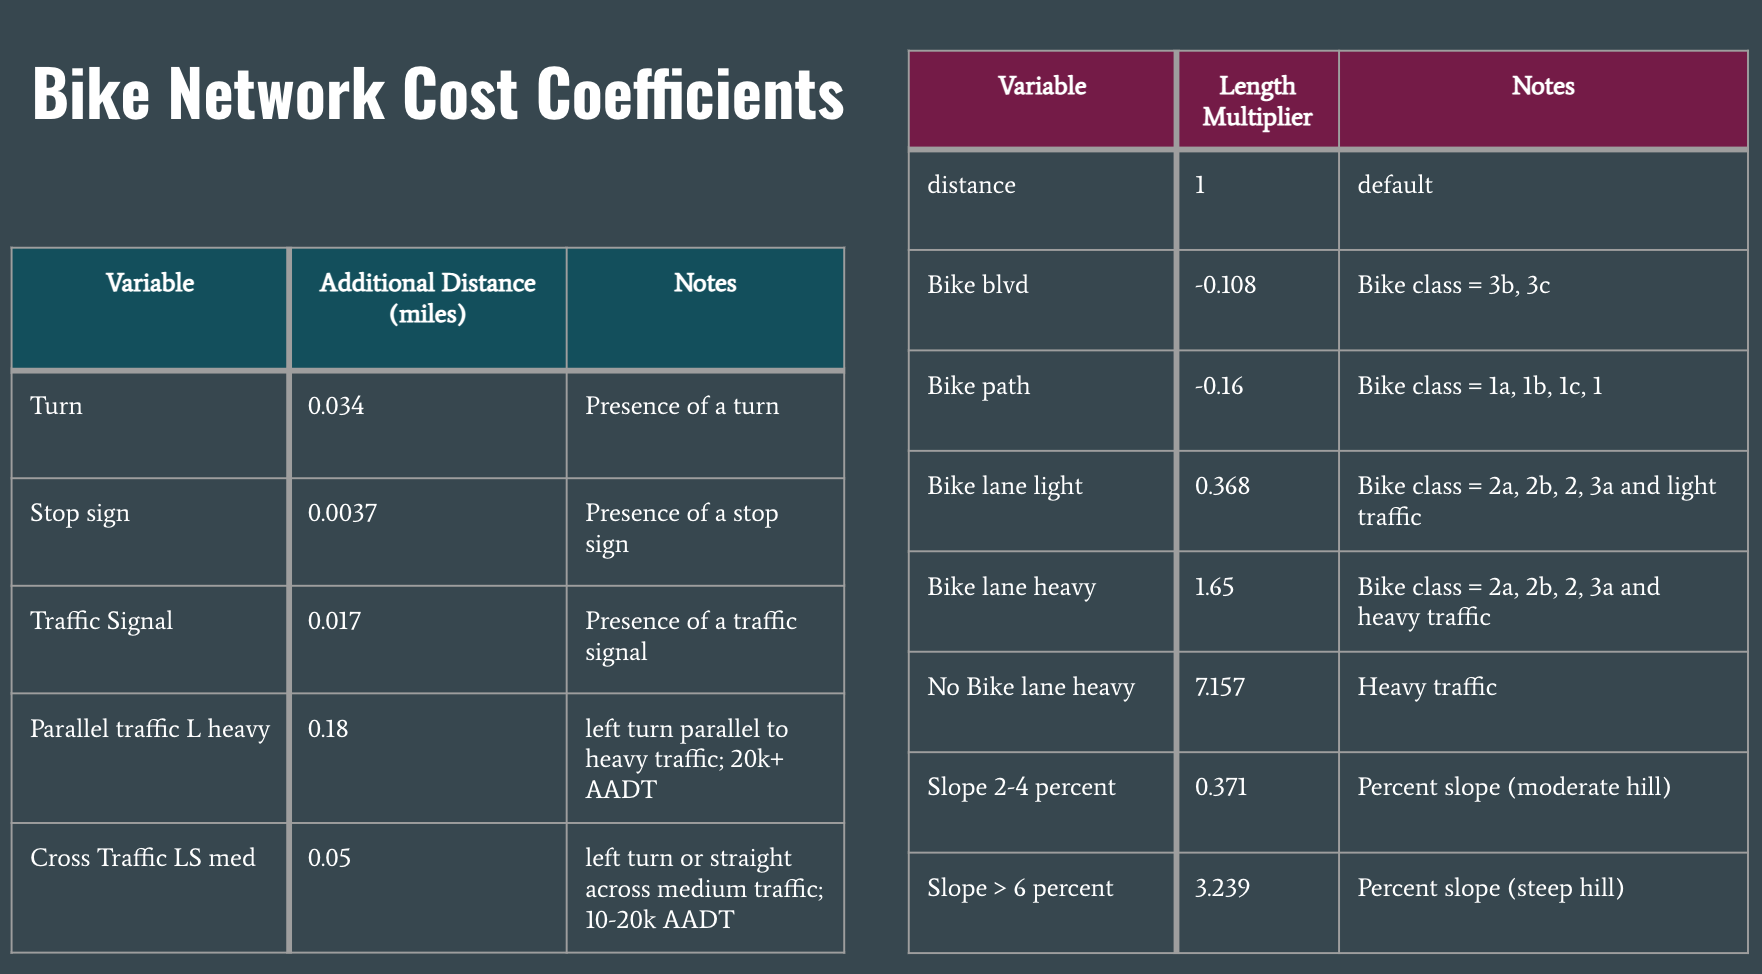


[Source](https://docs.google.com/presentation/d/1fQvYHh7uPFftrFy9jhumpmKOibdH3DvHHw39wTB1oh8/edit#slide=id.gef826ec669_0_92)

When installing new bicycle facilities on existing roadways, the multipliers below are used.

Project Type | Action 
---- | ----
Bike boulevard | Multiply length by ???
Bike lane (line) | Set length multiplier based on AADT - is > 10k, ??? else ???
Buffered bike lane (line) | Multiply length by ??
Protected bike lane (line) | Multiply length by ??
Shared lane (line) | No assumed impact
Share use path (line) | Multiply length by ??
Shoulder bikeway (line)  | Multiply length by ??



Project Type | Action 
---- | ----
Trail (line) | New connection
At-grade crossing (point) | No impact
Overpass (point)  | New connection
Underpass (point)  | New connection

All travel time and distances must be positive. Per Esri documentation:

    > The Network Analyst solvers do not support minimizing negative impedance values. If a cost attribute with negative values is used as the impedance attribute of a solver, the solver treats those network elements with negative values as prohibited.
    
If the AADT on a segment with a painted bike lane is > 15,000, the length multiplier is set to 0.9 rather than 0.3.